# Bitcoin - Interest rate connect

Taking Idea from the previous Quant Strategies for Crypto markets, In this notebook we are going to take a look into Bitcoin and Interes rate connect / disconnect

In [2]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt

### Data sources

Macro data - https://www.fxstreet.com/economic-calendar

Bitcoin data - https://www.kaggle.com/datasets/prasoonkottarathil/btcinusd or https://www.CryptoDataDownload.com

In [3]:
def import_data(file_path):
    data = pd.read_csv(file_path)
    return data

In [76]:
bitcoin = import_data('data/Crypto/Binance_BTCUSDT_d.csv')

In [77]:
fed = import_data('data/Interest Rates - US.csv')

In [78]:
fed['DATE'] = pd.to_datetime(fed['DATE'], format='%m/%d/%Y')
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])

In [79]:
fed['Date'] = fed['DATE']

In [80]:
bitcoin['Date'][-1:]


2042   2017-08-17
Name: Date, dtype: datetime64[ns]

In [81]:
fed = fed[(fed['DATE'].dt.year > 2017) | ((fed['DATE'].dt.year == 2017) & (fed['DATE'].dt.month >=7))]  # Filter out rows with dates past 2017

In [82]:
fed['Date'][-1:]

46   2017-07-26
Name: Date, dtype: datetime64[ns]

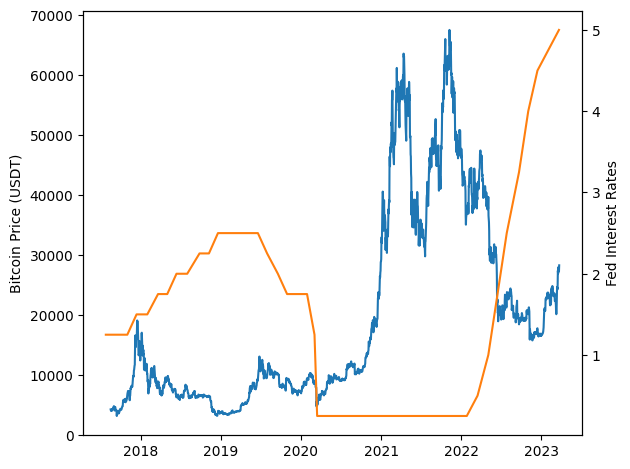

In [83]:
fig, ax1 = plt.subplots(sharex=True)
ax2 = ax1.twinx()

ax1.plot(bitcoin['Date'], bitcoin['Close'], label='Bitcoin Prices', color='C0')
ax2.plot(fed['DATE'], fed['ACTUAL'], label='Fed Interest Rates', color='C1')

ax1.set_ylabel('Bitcoin Price (USDT)')
ax2.set_ylabel('Fed Interest Rates')

fig.tight_layout()
plt.show()

In [84]:
import pandas as pd

# Read in the dataframes
fed_df = fed.copy()
bitcoin_df = bitcoin.copy()

fed_df['Date'] = pd.to_datetime(fed_df['Date'])
bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Date'])
# Set the date columns as the index
fed_df.set_index('Date', inplace=True)
bitcoin_df.set_index('Date', inplace=True)

# Merge the dataframes based on the date column
merged_df = pd.merge(fed_df, bitcoin_df, how='outer', left_index=True, right_index=True)

# Forward fill
merged_df['ACTUAL'].fillna(method='ffill', inplace=True)
merged_df['Fed Rate Changed'] = merged_df['ACTUAL'].diff() != 0


In [87]:
merged_df = merged_df.drop(columns=['DEV', 'CONS', 'Unix', 'Symbol', 'Volume BTC'])

In [89]:
merged_df = merged_df.drop(columns=['tradecount', 'Volume USDT'])

In [156]:
merged_df.tail(10)

,DATE,ACTUAL,Open,High,Low,Close,Fed Rate Changed,Days Since Fed Rate Change
new_index,,,,,,,,
2034,NaT,4.75,20455.73,22150.00,20270.60,21997.11,False,19
2035,NaT,4.75,21998.05,24500.00,21813.88,24113.48,False,19
2036,NaT,4.75,24112.27,26386.87,23976.42,24670.41,False,19
2037,NaT,4.75,24670.41,25196.97,23896.95,24285.66,False,19
2038,NaT,4.75,24285.66,25167.40,24123.00,24998.78,False,19
2039,NaT,4.75,24998.78,27756.84,24890.00,27395.13,False,19
2040,NaT,4.75,27395.13,27724.85,26578.00,26907.49,False,19
2041,NaT,4.75,26907.49,28390.10,26827.22,27972.87,False,19
2042,2023-03-22,5.00,28107.81,28868.05,26601.80,27250.97,True,20


In [111]:
merged_df['new_index'] = range(len(merged_df))
merged_df.set_index('new_index', inplace=True)

In [129]:
merged_df.head()

,DATE,ACTUAL,Open,High,Low,Close,Fed Rate Changed,Days Since Fed Rate Change
new_index,,,,,,,,
0,2017-07-26,1.25,NaN,NaN,NaN,NaN,True,1
1,NaT,1.25,4261.48,4485.39,4200.74,4285.08,False,1
2,NaT,1.25,4285.08,4371.52,3938.77,4108.37,False,1
3,NaT,1.25,4108.37,4184.69,3850.00,4139.98,False,1
4,NaT,1.25,4120.98,4211.08,4032.62,4086.29,False,1


In [381]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [354]:
prev = None
perDay = pd.DataFrame(columns=['0', '1', '2', '3', '4', '5', 'Pos'])
new_row = pd.DataFrame({'0': np.nan, '1': np.nan, '2': np.nan, '3': np.nan, '4': np.nan, 'Pos': False}, index=[len(perDay)])

bitcoin_performance = pd.DataFrame(columns=['Days Since Fed Rate Change', 'Bitcoin Return', 'Pos / Neg'])
overall_change = []
pos_announcement = []
neg_announcement = []

for index, row in merged_df.iterrows():
    if pd.isnull(row['Open']) or row['Fed Rate Changed'] is False:
        prev = row
        continue
    next_five_values = merged_df.loc[index:index+5, 'Close']
    first_value = next_five_values.iloc[0]
    percentage_changes = ((next_five_values - first_value) / first_value) * 100

    pos = False if row['ACTUAL'] > prev['ACTUAL'] else True
    
    perDay = perDay.append(new_row, ignore_index = True)

    for i in range(len(percentage_changes)):
        perDay[str(i)][len(perDay[str(i)]) - 1] = percentage_changes.iloc[i]
    perDay['Pos'][len(perDay['Pos']) - 1] = pos

    bitcoin_returns = next_five_values.pct_change().iloc[:5]
    change = ((next_five_values.iloc[-1] - next_five_values.iloc[0]) / next_five_values.iloc[0]) * 100
    overall_change.append(change)
    
    if not pos:
        neg_announcement.append(change)
    else:
        pos_announcement.append(change)

    count =0
    for j in range(len(bitcoin_returns)):
        bitcoin_performance = bitcoin_performance.append({'Days Since Fed Rate Change': count,
                                                              'Bitcoin Return': bitcoin_returns.iloc[j], 'Pos / Neg': pos}, ignore_index=True)
        count = count + 1
    prev = row

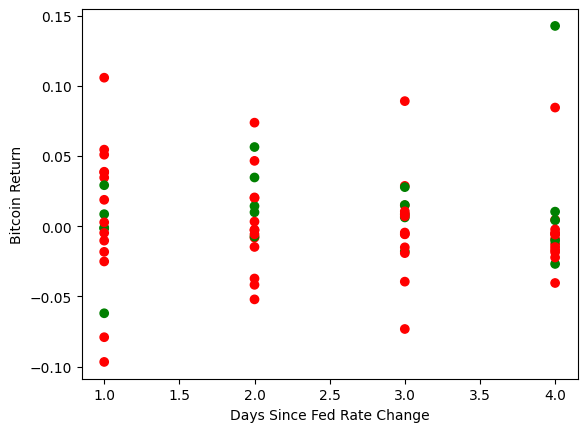

In [355]:
# Plot the Bitcoin performance data
import matplotlib.pyplot as plt

plt.scatter(bitcoin_performance['Days Since Fed Rate Change'], bitcoin_performance['Bitcoin Return'], c=bitcoin_performance['Pos / Neg'].replace({True: 'g', False: 'r'}))
plt.xlabel('Days Since Fed Rate Change')
plt.ylabel('Bitcoin Return')
plt.show()


In [356]:
perDay.kurtosis()

0      0.000000
1      0.541653
2      0.571831
3      1.985302
4      0.710425
5      0.532939
Pos   -0.718487
dtype: float64

In [357]:
last_row_index = perDay.index[-1]

# Drop the last row from the DataFrame
perDay = perDay.drop(last_row_index)

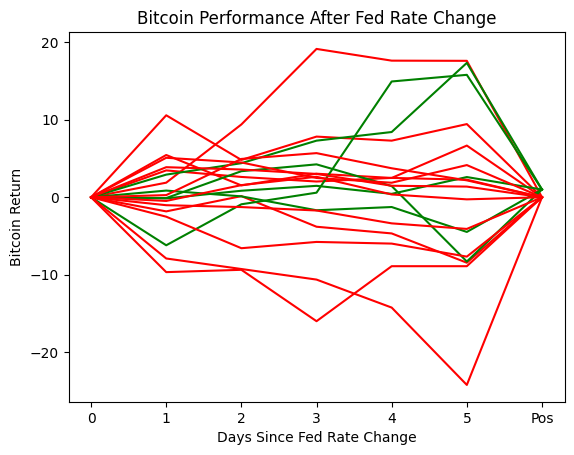

In [358]:
for i, row in perDay.iterrows():
    new_row = row.drop(columns=['Pos'])
    plt.plot(row, label=i, color='green' if row['Pos'] == True else 'red')

# Add labels and legend
plt.xlabel('Days Since Fed Rate Change')
plt.ylabel('Bitcoin Return')
plt.title('Bitcoin Performance After Fed Rate Change')
# plt.legend()

# Display the plot
plt.show()


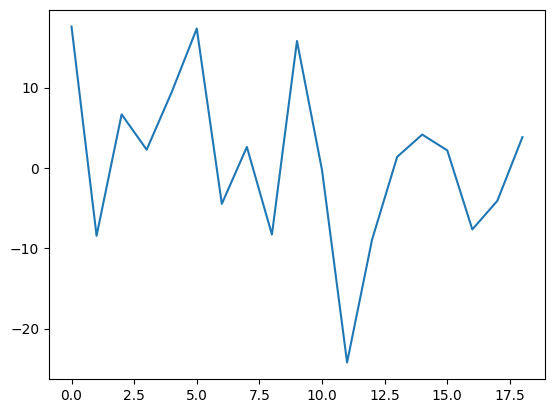

In [364]:
plt.plot(overall_change)

In [365]:
print("Avg change after positive announcement or decrease in rates after 5 days: " + str(sum(pos_announcement) / len(pos_announcement)))
print("Avg change after negative announcement or increase in rates after 5 days: " + str(sum(neg_announcement) / len(neg_announcement)))

Avg change after positive announcement or decrease in rates after 5 days: 4.595160350216892
Avg change after negative announcement or increase in rates after 5 days: -0.4336280537050022


In [369]:
relation_df = pd.DataFrame(columns=['Rate change', 'Price change'])
for ele in pos_announcement:
    relation_df = relation_df.append({'Rate change': 1, 'Price change': ele}, ignore_index=True)
for ele in neg_announcement:
    relation_df = relation_df.append({'Rate change': 0, 'Price change': ele}, ignore_index=True)
relation_df

,Rate change,Price change
0,1.0,17.343037
1,1.0,-4.477114
2,1.0,2.606634
3,1.0,-8.296281
4,1.0,15.799526
5,0.0,17.606867
6,0.0,-8.449859
7,0.0,6.669230
8,0.0,2.265851
9,0.0,9.442087


In [372]:
# Calculate the correlation coefficient
corr_coef = relation_df['Rate change'].corr(relation_df['Price change'])
print("Correlation coefficient:", corr_coef)


Correlation coefficient: 0.2196465841846656


In [384]:
import statsmodels.api as sm

# Simple linear regression model
model = sm.formula.ols(formula='Q("Price change") ~ Q("Rate change")', data=relation_df).fit()

print(model.summary())



                            OLS Regression Results                            
Dep. Variable:      Q("Price change")   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.8617
Date:                Sun, 26 Mar 2023   Prob (F-statistic):              0.366
Time:                        05:31:10   Log-Likelihood:                -70.394
No. Observations:                  19   AIC:                             144.8
Df Residuals:                      17   BIC:                             146.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.4336      2.779  